In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder
FOLDERNAME = 'cs231n/final_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
# Tutorial followed: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler, Subset
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import os
import time

import pandas as pd
import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
# print_every = 300
batch_size = 64
len_data = 12800
input_size = 299
data_dir = '/content/drive/My Drive/Stanford/final_project/all_fish_pics/'
print('using device:', device)

using device: cuda


In [3]:
classes = os.listdir(data_dir)

In [4]:
train_tfms = T.Compose([
    T.Resize(299), 
    T.ToTensor()
])

all_data = ImageFolder(data_dir, transform=train_tfms)
num_classes = len(all_data.class_to_idx)
all_data = Subset(all_data, np.random.choice(len(all_data), len_data, replace=False))
print(all_data[0][0].shape)
print(len(all_data))

train_len = int(len_data*0.7)
val_len = int(len_data*0.2)
test_len = len_data - (train_len + val_len)
train, val, test = torch.utils.data.random_split(all_data, [train_len, val_len, test_len])
train_dl = DataLoader(train, batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_dl = DataLoader(val, batch_size, num_workers=2, shuffle=True, pin_memory=True)
test_dl = DataLoader(test, batch_size, shuffle=True, pin_memory=True)

dataloaders = {'train': train_dl, 'val': val_dl}

torch.Size([3, 299, 299])
12800


In [5]:
def train_model(model, dataloaders, criterion, optimizer, name='inception_v3_generic', num_epochs=25, is_inception=True):
    since = time.time()

    val_acc_history = []
    val_acc3_history = []
    train_acc_history = []
    train_acc3_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_corrects3 = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # acc@3
                _, pred = outputs.topk(3, 1, True, True)
                pred = pred.t()
                correct = pred.eq(labels.view(1, -1).expand_as(pred))
                correct_k = correct[:3].reshape(-1).float().sum(0)
                running_corrects3 += correct_k

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc3 = running_corrects3.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f} Acc@3: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc3))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Saving model...')
                torch.save(model.state_dict(), f'/content/drive/My Drive/{FOLDERNAME}results/{name}.pth')
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_acc3_history.append(epoch_acc3.item())
            else: 
                train_acc_history.append(epoch_acc.item())
                train_acc3_history.append(epoch_acc3.item())

        print("Saving training history...")
        data = pd.DataFrame(
            {'epoch': list(range(epoch + 1)), 
             'train_acc': train_acc_history, 
             'val_acc': val_acc_history, 
             'train_acc3': train_acc3_history, 
             'val_acc3': val_acc3_history})
        data.to_csv(f'/content/drive/My Drive/{FOLDERNAME}results/{name}.csv')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def set_parameter_requires_grad(model, feature_extracting=True): 
  if feature_extracting: 
    for param in model.parameters(): 
      param.requires_grad = False

In [9]:
def initialize_model(num_classes, feature_extract=True, use_pretrained=True): 
  model_ft = None
  input_size = 0
  model_ft = models.inception_v3(pretrained=use_pretrained)
  set_parameter_requires_grad(model_ft, feature_extract)
  # Handle the auxiliary net
  num_ftrs = model_ft.AuxLogits.fc.in_features
  model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
  # model_ft.AuxLogits.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Linear(512, num_classes))
  # Handle the primary net
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, num_classes)
  # model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 512), nn.ReLU(), nn.Linear(512, num_classes))
  input_size = 299
  return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, True, False)
print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [10]:
# Send model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized / updated in this run. If we are
# finetuning we will be updating all parameters. However, if we are doing
# feature extract method, we will only update the parameters that we have 
# just initialized, i.e. the parameters with requires_grad = True
params_to_update = model_ft.parameters()
print("Params to learn:")
params_to_update = []
for name, param in model_ft.named_parameters():
  if param.requires_grad == True: 
    params_to_update.append(param)
    print('\t', name)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [11]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, name='inception_v3_30_epochs_all_12800dpts_adam_twofc', num_epochs=30, is_inception=True)

Epoch 0/29
----------


KeyboardInterrupt: ignored

In [ ]:
# Plot the training curve of validation accuracy vs. number of epochs
ohist = hist

plt.title("Validation accuracy vs. Number of Training Epochs")
plt.xlabel("Training epoch")
plt.ylabel("Validation accuracy")
plt.plot(range(1, 31), ohist, label="Inception V3")
plt.ylim((0, 1.))
plt.xticks(np.arange(1, 31, 1.0))
plt.legend()
plt.show()

In [ ]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

In [ ]:
def check_accuracy(loader, model, threshold = 3):
    num_correct = 0
    num_samples = 0

    num_correct3 = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            # check accuracy with predicted result
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
            # check acc@3
            _, pred = scores.topk(threshold, 1, True, True)
            pred = pred.t()
            correct = pred.eq(y.view(1, -1).expand_as(pred))

            correct_k = correct[:threshold].reshape(-1).float().sum(0)
            num_correct3 += correct_k

        acc = float(num_correct) / num_samples
        acc3 = float(num_correct3) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print(f'Got acc@{threshold}: {acc3 * 100}\%')
        return 100*acc, 100*acc3

In [ ]:
def train(model, optimizer, lr_scheduler, epochs=1, name='generic_run'):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for    
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    accs = []
    accs_top3 = []
    best_acc = -1
    for e in range(epochs):
        print(f'Epoch {e+1}')
        for t, (x, y) in enumerate(train_dl):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

        acc, accs3 = check_accuracy(val_dl, model)
        print(f'best_acc: {best_acc}')
        print(f'acc: {acc}')
        if acc > best_acc: 
          print('Saving model...')
          torch.save(model.state_dict(), f'/content/drive/My Drive/{FOLDERNAME}results/{name}.pth')
          best_acc = acc
        accs.append(acc)
        accs_top3.append(accs3)
    data = pd.DataFrame({'epoch': list(range(epochs)), 'acc': accs, 'acc_3': accs_top3})
    data.to_csv(f'/content/drive/My Drive/{FOLDERNAME}results/{name}.csv')

    return accs, accs_top3

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet(nn.Module):
  def __init__(self, in_channel, out_channel):
    super().__init__()

    # Define the layers

    self.conv1 = conv_block(in_channels, 128)
    self.conv2 = conv_block(128, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
    self.drop1 = nn.Dropout(0.5)

    self.conv3 = conv_block(128, 256)
    self.conv4 = conv_block(256, 256, pool=True)
    self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
    self.drop2 = nn.Dropout(0.5)

    self.conv5 = conv_block(256, 512)
    self.conv6 = conv_block(512, 512, pool=True)
    self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
    self.drop3 = nn.Dropout(0.5)

    self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(8*256*256, out_channel))

  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.drop1(out)

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.drop2(out)
        
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    out = self.drop3(out)

    scores = self.classifier(out)
    return scores


In [ ]:
def plot_accuracies(learning_rates,accuracies, labels):
    for i,acc in enumerate(accuracies):
        plt.plot(learning_rates, acc, label = labels[i])
    plt.legend()
    plt.xlabel("learning rate")
    plt.ylabel("final validation accuracy")
    plt.title("Validation accuracy vs learning rate")

In [ ]:
lr = 1e-4
in_channels = 3
num_epochs = 30

model = ResNet(in_channels,len(classes))
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

accs,accs_top3 = train(model, optimizer, scheduler, epochs=num_epochs, name='resnet_large_top_20')


print(accs)
print(accs_top3)
labels = ['ResNet','ResNet top 3']
epochs = np.arange(num_epochs)
plot_accuracies(epochs,[accs,accs_top3],labels)

In [ ]:
def load_model(model, path): 
  '''
  Load model from saved parameters.
  '''
  model.load_state_dict(torch.load(path))
  model.to(device)
  model.eval()
  return model

# test_model = ResNet(in_channels,len(classes))
# test_model.load_state_dict(torch.load(f'/content/drive/My Drive/{FOLDERNAME}results/test_run_small_data.pth'))
# test_model.to(device)
# os.listdir(f'/content/drive/My Drive/{FOLDERNAME}results')
# test_model.eval()
# test_model = load_model(test_model, f'/content/drive/My Drive/{FOLDERNAME}results/test_run_small_data.pth')

In [ ]:
learning_rates = [1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3]
in_channels = 3

models_accs = []
for lr in learning_rates:
  model = ResNet(in_channels,len(classes))
  optimizer = optim.SGD(model.parameters(), lr = lr)

  acc = train(model,optimizer,epochs=5)
  models_accs.append(acc)

print(models_accs)
plot_accuracies(learning_rates,models_accs)

TypeError: ignored

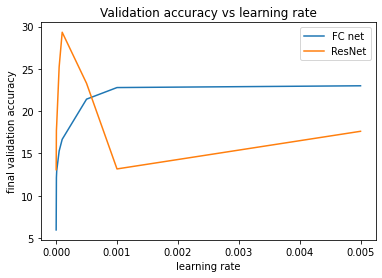

In [ ]:
lrs = [1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3]
accs_1 = [5.96,12.125,12.96,15.29,16.67,21.42,22.79,23.0]
accs_2 = [13.08,17.71,18.46,25.23,29.33,23.29,13.17,17.62]
accs = [accs_1,accs_2]
labels = ['FC net','ResNet']
plot_accuracies(lrs,accs,labels)

In [ ]:
learning_rates = [1e-4,5e-4,1e-5,5e-5]
in_channels = 3

models_dict = {}
for lr in learning_rates:
  model = TestResNet(in_channels,len(classes))
  optimizer = optim.SGD(model.parameters(), lr = lr)

  acc = train(model,optimizer,epochs=5)
  models_dict[lr] = acc

print(models_dict)

Iteration 0, loss = 6.3884
Got 0 / 2400 correct (0.00)

Iteration 50, loss = 9.0414
Got 289 / 2400 correct (12.04)

Iteration 100, loss = 11.1241
Got 320 / 2400 correct (13.33)

Iteration 150, loss = 10.7040
Got 210 / 2400 correct (8.75)

Iteration 200, loss = 6.1676
Got 396 / 2400 correct (16.50)

Iteration 250, loss = 7.0101
Got 352 / 2400 correct (14.67)

Iteration 300, loss = 5.1978
Got 333 / 2400 correct (13.88)

Iteration 0, loss = 6.8368
Got 344 / 2400 correct (14.33)

Iteration 50, loss = 5.2860
Got 394 / 2400 correct (16.42)

Iteration 100, loss = 7.5562
Got 368 / 2400 correct (15.33)

Iteration 150, loss = 7.8870
Got 420 / 2400 correct (17.50)

Iteration 200, loss = 4.4828
Got 422 / 2400 correct (17.58)

Iteration 250, loss = 6.3886
Got 327 / 2400 correct (13.63)

Iteration 300, loss = 3.5935
Got 608 / 2400 correct (25.33)

Iteration 0, loss = 4.3686
Got 573 / 2400 correct (23.88)

Iteration 50, loss = 3.4967
Got 604 / 2400 correct (25.17)

Iteration 100, loss = 4.1616
Got 53

In [ ]:
class ThreeLayerFC(nn.Module):
  def __init__(self, in_channel, channel_1, channel_2, num_classes):
    super().__init__()

    # Define the layers
    # self.conv_1 = nn.Conv2d(in_channel,channel_1,(5,5),padding=2)
    # nn.init.kaiming_normal_(self.conv_1.weight)
    # self.conv_2 = nn.Conv2d(channel_1,channel_2,(3,3),padding=1)
    # nn.init.kaiming_normal_(self.conv_2.weight)

    self.fc1 = nn.Linear(in_channel*256*256,channel_1)
    nn.init.kaiming_normal_(self.fc1.weight)

    self.fc2 = nn.Linear(channel_1,channel_2)
    nn.init.kaiming_normal_(self.fc2.weight)

    self.fc3 = nn.Linear(channel_2,num_classes)
    nn.init.kaiming_normal_(self.fc3.weight)

  def forward(self,x):
    x = flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    scores = self.fc3(x)
    return scores


Epoch 1
Got 396 / 2400 correct (16.50)
Epoch 2
Got 463 / 2400 correct (19.29)
Epoch 3
Got 502 / 2400 correct (20.92)
Epoch 4
Got 528 / 2400 correct (22.00)
Epoch 5
Got 547 / 2400 correct (22.79)
Epoch 1
Got 403 / 2400 correct (16.79)
Epoch 2
Got 502 / 2400 correct (20.92)
Epoch 3
Got 533 / 2400 correct (22.21)
Epoch 4
Got 536 / 2400 correct (22.33)
Epoch 5
Got 552 / 2400 correct (23.00)
Epoch 1
Got 308 / 2400 correct (12.83)
Epoch 2
Got 340 / 2400 correct (14.17)
Epoch 3
Got 367 / 2400 correct (15.29)
Epoch 4
Got 380 / 2400 correct (15.83)
Epoch 5
Got 400 / 2400 correct (16.67)
Epoch 1
Got 376 / 2400 correct (15.67)
Epoch 2
Got 430 / 2400 correct (17.92)
Epoch 3
Got 442 / 2400 correct (18.42)
Epoch 4
Got 473 / 2400 correct (19.71)
Epoch 5
Got 514 / 2400 correct (21.42)
Epoch 1
Got 228 / 2400 correct (9.50)
Epoch 2
Got 226 / 2400 correct (9.42)
Epoch 3
Got 241 / 2400 correct (10.04)
Epoch 4
Got 288 / 2400 correct (12.00)
Epoch 5
Got 311 / 2400 correct (12.96)
Epoch 1
Got 312 / 2400 corr

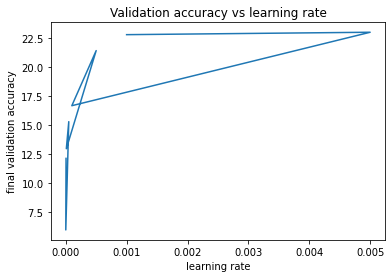

In [ ]:
learning_rates = [1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6]
channel_1 = 1000
channel_2 = 500

models_accs = []
for lr in learning_rates:
  model = ThreeLayerFC(3,channel_1,channel_2,len(classes))
  optimizer = optim.SGD(model.parameters(), lr = lr)

  acc = train(model, optimizer, epochs=5)
  models_accs.append(acc)

print(models_accs)
plot_accuracies(learning_rates,models_accs)

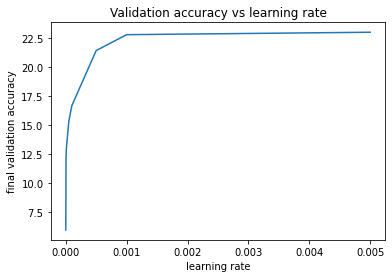

In [ ]:
lrs = [1e-6,5e-6,1e-5,5e-5,1e-4,5e-4,1e-3,5e-3]
accs = [5.96,12.125,12.96,15.29,16.67,21.42,22.79,23.0]
plot_accuracies(lrs,accs)

Epoch 1
Got 413 / 2400 correct (17.21)
Epoch 2
Got 508 / 2400 correct (21.17)
Epoch 3
Got 578 / 2400 correct (24.08)
Epoch 4
Got 638 / 2400 correct (26.58)
Epoch 5
Got 619 / 2400 correct (25.79)
Epoch 6
Got 721 / 2400 correct (30.04)
Epoch 7
Got 750 / 2400 correct (31.25)
Epoch 8
Got 746 / 2400 correct (31.08)
Epoch 9
Got 774 / 2400 correct (32.25)
Epoch 10
Got 801 / 2400 correct (33.38)
Epoch 11
Got 742 / 2400 correct (30.92)
Epoch 12
Got 742 / 2400 correct (30.92)
Epoch 13
Got 799 / 2400 correct (33.29)
Epoch 14
Got 813 / 2400 correct (33.88)
Epoch 15
Got 808 / 2400 correct (33.67)
Epoch 16
Got 791 / 2400 correct (32.96)
Epoch 17
Got 811 / 2400 correct (33.79)
Epoch 18
Got 809 / 2400 correct (33.71)
Epoch 19
Got 816 / 2400 correct (34.00)
Epoch 20
Got 812 / 2400 correct (33.83)
[17.208333333333332, 21.166666666666668, 24.083333333333336, 26.583333333333332, 25.791666666666668, 30.041666666666668, 31.25, 31.083333333333336, 32.25, 33.375, 30.916666666666664, 30.916666666666664, 33.291

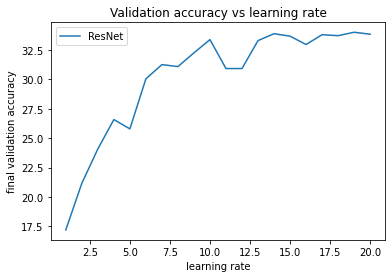

In [ ]:
learning_rates = [1e-4]
in_channels = 3

accs = []
for lr in learning_rates:
  model = ResNet(in_channels,len(classes))
  optimizer = optim.SGD(model.parameters(), lr = lr)

  accs = train(model,optimizer,epochs=20)


print(accs)
labels = ['ResNet']
epochs = np.arange(1,21)
plot_accuracies(epochs,[accs],labels)

TODO:

Make new dataset folder

Create new models

1. VGG Net
2. AlexNet
3. Improved ResNet

Plot accuracies over 30 epochs for each

In [ ]:
# skeleton code for training loop of multiple models
vgg = VGGNet(..., ..., name='VGGNet')
alexnet = AlexNet(..., ..., name=...)
resnet = ResNet(..., ..., name=...)

lr = 1e-4
num_epochs = 15
in_channels = 3

for model in (vgg, alexnet, resnet): 
  name = 'name_of_model'
  optimizer = optim.Adam(model.parameters(), lr = lr)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  accs, accs_top3 = train(model, optimizer, scheduler, epochs=num_epochs, name='test_run_small_data')


print(accs)
print(accs_top3)
labels = ['ResNet','ResNet top 3']
epochs = np.arange(num_epochs)
plot_accuracies(epochs,[accs,accs_top3],labels)